In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.manifold import TSNE
import seaborn as sns
import shap

d:\software\anaconda\envs\pt1.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#data = pd.read_csv("letterdate.csv")
data = pd.read_excel("data.xlsx")
col = data.columns.tolist()[:16]
true_labels = np.unique(data["Class"])
true_labels = ['An I', 'An II', 'An III', 'OJ', 'PJ']
original_labels = data["Class"]
print(true_labels)
label_encoder = LabelEncoder()
data["Class"] = label_encoder.fit_transform(data['Class'])

data = data.values
labels = np.array(data[:, -1], dtype=int) #(1274,)
data = data[:, :-1] #(1274,) (1274, 8)
print(data.shape)
print(labels.shape)

['An I', 'An II', 'An III', 'OJ', 'PJ']
(1440, 16)
(1440,)


In [3]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [4]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # 训练模型
    model.fit(X_train, y_train)

    # 预测
    y_pred = model.predict(X_test)

    # 准确度评估
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    cm_df = pd.DataFrame(cm, index=true_labels, columns=true_labels)
    cm_df = cm_df.div(cm_df.sum(axis=1), axis=0) #归一化
    plt.figure(figsize=(8, 6))
    # sns.set()
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f")
    plt.title(name + " Overall accuracy: " + f"{accuracy:.4f}", fontweight="bold") #Confusion matrix
    plt.xlabel("Predicted", fontweight="bold")
    plt.ylabel("True", fontweight="bold")
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    plt.savefig(f'Confusion Matrix_{name}', bbox_inches='tight', dpi=600)
    #plt.show()

    # ROC曲线
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    elif hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)#[:, 1]
    else:
        raise AttributeError("The selected model does not have decision_function or predict_proba")

    # 多类别情况下，将标签二值化
    if len(np.unique(labels)) > 2:
        y_test_bin = label_binarize(y_test, classes=np.unique(labels))
    else:
        y_test_bin = y_test

    # 计算每个类别的ROC曲线和AUC值
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(np.unique(labels).shape[0]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 计算 macro-average AUC
    macro_auc = np.mean(list(roc_auc.values()))
    print(f"Macro Avg AUC :{macro_auc:.6f}")

    # 绘制ROC曲线
    plt.figure(figsize=(8, 6))
    for i in range(np.unique(labels).shape[0]):
        plt.plot(fpr[i], tpr[i], label=f'{true_labels[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='white', alpha=0, label=f'Avg AUC = {macro_auc:.4f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.text(0.6, 0.4, f'Macro Avg AUC = {macro_auc:.2f}', bbox=dict(facecolor='white', alpha=0.5))
    plt.title(name + ' ROC Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'ROC Curve_{name}', bbox_inches='tight', dpi=600)
    #plt.show()

    if name == 'XGBoost' or name == 'Random Forest':
        # Create an explainer object    
        explainer = shap.Explainer(model)
        shap_values = explainer.shap_values(X_test)

        # Plot the SHAP value impact graph
        plt.figure(figsize=(8, 6))
        shap.summary_plot(shap_values[0], X_test, show=False)
        plt.title(f'{name}')
        plt.tight_layout()
        plt.savefig(f'shap_summary_plot_{name}', bbox_inches='tight', dpi=600)

        # Plot the SHAP decisiooooon graph
        plt.figure(figsize=(8, 6))
        if isinstance(explainer.expected_value, np.ndarray):
            shap.multioutput_decision_plot(explainer.expected_value.tolist(), shap_values, row_index=0, show=False)
        else:
            shap.multioutput_decision_plot(explainer.expected_value, shap_values, row_index=0, show=False)
        plt.title(f'{name}')
        plt.tight_layout()
        plt.savefig(f'shap_decision_plot_{name}', bbox_inches='tight', dpi=600)

In [5]:
# 选择分类器并评估
classifiers = {
    "XGBoost": xgb.XGBClassifier(),
}

Accuracy: 0.8854166666666666
Confusion Matrix:
[[67  0  3  0  5]
 [ 5 57  2  0  0]
 [ 6  1 65  0  0]
 [ 0  0  1 36  2]
 [ 6  0  2  0 30]]
Macro Avg AUC :0.980690


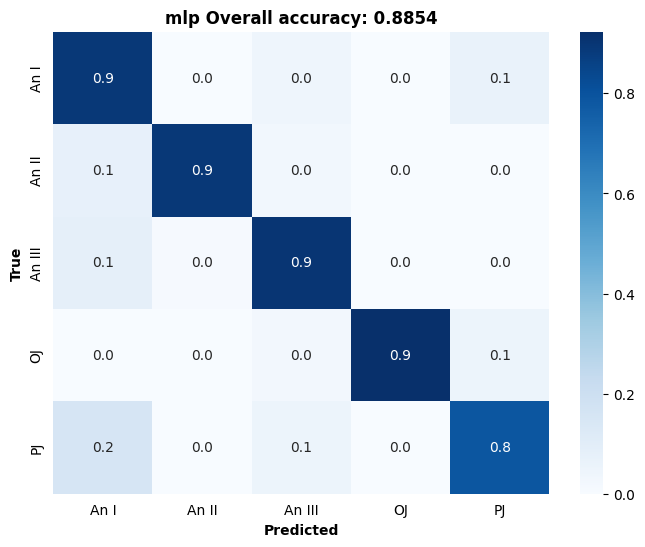

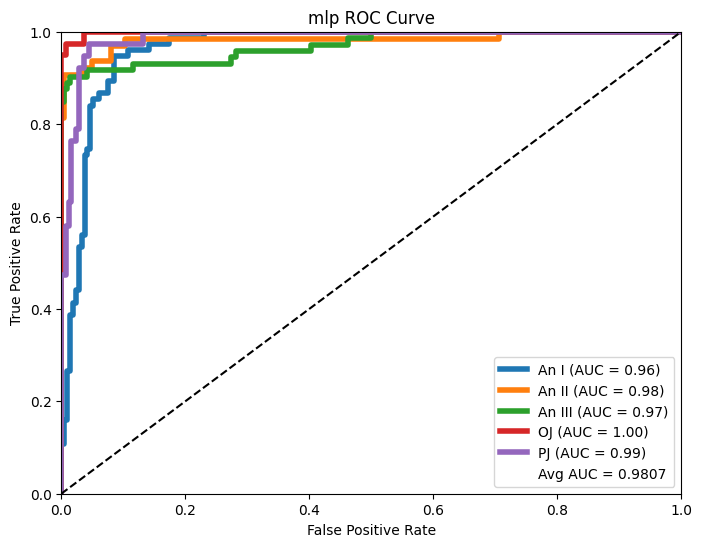

In [6]:
model = MLPClassifier()
model.fit(X_train, y_train)
name = 'mlp'
# 预测
y_pred = model.predict(X_test)

# 准确度评估
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{cm}")

cm_df = pd.DataFrame(cm, index=true_labels, columns=true_labels)
cm_df = cm_df.div(cm_df.sum(axis=1), axis=0) #归一化
plt.figure(figsize=(8, 6))
# sns.set()
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt=".1f")
plt.title(name + " Overall accuracy: " + f"{accuracy:.4f}", fontweight="bold") #Confusion matrix
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")
ax = plt.gca()
ax.tick_params(bottom=False, top=False, left=False, right=False)
# plt.savefig(f'Confusion Matrix_{name}', bbox_inches='tight', dpi=600)
#plt.show()

# ROC曲线
if hasattr(model, "decision_function"):
    y_score = model.decision_function(X_test)
elif hasattr(model, "predict_proba"):
    y_score = model.predict_proba(X_test)#[:, 1]
else:
    raise AttributeError("The selected model does not have decision_function or predict_proba")

# 多类别情况下，将标签二值化
if len(np.unique(labels)) > 2:
    y_test_bin = label_binarize(y_test, classes=np.unique(labels))
else:
    y_test_bin = y_test

# 计算每个类别的ROC曲线和AUC值
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(np.unique(labels).shape[0]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算 macro-average AUC
macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro Avg AUC :{macro_auc:.6f}")

# 绘制ROC曲线
plt.figure(figsize=(8, 6))
for i in range(np.unique(labels).shape[0]):
    plt.plot(fpr[i], tpr[i], lw=4, label=f'{true_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='white', alpha=0, label=f'Avg AUC = {macro_auc:.4f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.text(0.6, 0.4, f'Macro Avg AUC = {macro_auc:.2f}', bbox=dict(facecolor='white', alpha=0.5))
plt.title(name + ' ROC Curve')
plt.legend(loc="lower right")

The figure layout has changed to tight


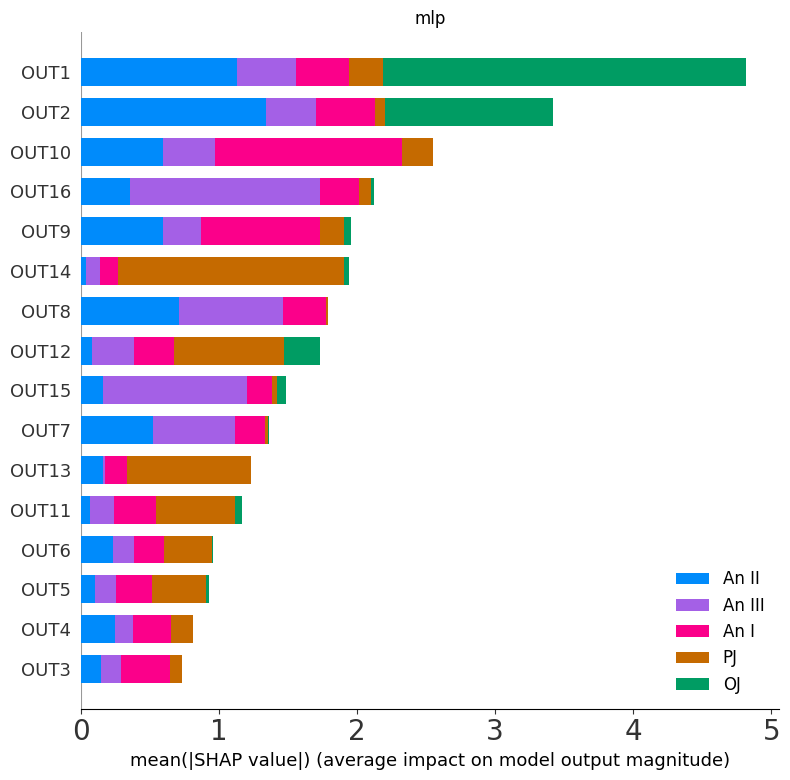

In [7]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# Plot the SHAP value impact graph
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values, X_test, feature_names=col, class_names=true_labels, show=False)
plt.xticks(size=20)
plt.title(f'{name}')
plt.tight_layout()

In [24]:
np.mean(abs(shap_values[1]), axis=0)

array([1.1329532 , 1.3380908 , 0.14433499, 0.24864033, 0.10369568,
       0.22898377, 0.52240145, 0.7118783 , 0.5903937 , 0.5898627 ,
       0.062128  , 0.07967773, 0.15813152, 0.03281153, 0.16218655,
       0.3567132 ], dtype=float32)

In [27]:
explainer.expected_value

[0.96403104, 0.6596751, 0.78984827, -0.5868243, 0.30396545]

In [31]:
shap_values[0].shape

(288, 16)

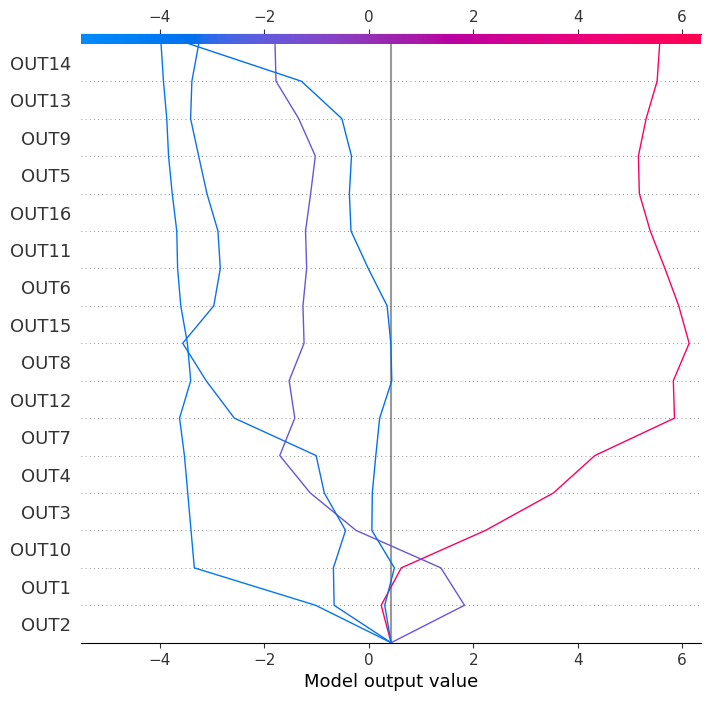

In [25]:
shap.multioutput_decision_plot(explainer.expected_value, shap_values, feature_names=col, row_index=0, show=False)

In [8]:
shap_values[0].shape

(288, 16)

In [11]:
np.savetxt('x.csv', shap_values[0], delimiter=',')

The figure layout has changed to tight
The figure layout has changed to tight


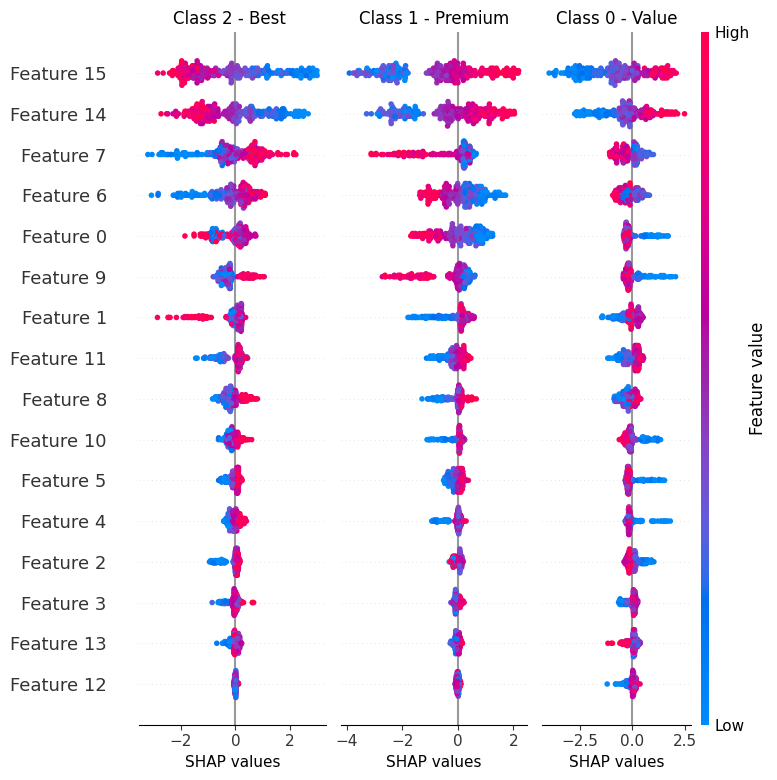

In [140]:
fig = plt.figure(figsize=(8, 6))

ax0 = fig.add_subplot(131)
ax0.title.set_text('Class 2 - Best ')
shap.summary_plot(shap_values[2], X_test, show=False, color_bar=False)
ax0.set_xlabel(r'SHAP values', fontsize=11)
# plt.subplots_adjust(wspace = 5)

ax1 = fig.add_subplot(132)
ax1.title.set_text('Class 1 - Premium')
# ax1.set_yticks([])
shap.summary_plot(shap_values[1], X_test, show=False, color_bar=False)
ax1.set_yticks([])
# plt.subplots_adjust(wspace = 5)
ax1.set_xlabel(r'SHAP values', fontsize=11)
# fig.colorbar()

ax2 = fig.add_subplot(133)
ax2.title.set_text('Class 0 - Value')
shap.summary_plot(shap_values[0], X_test, show=False, color_bar=True)
ax2.set_yticks([])
ax2.set_xlabel(r'SHAP values', fontsize=11)

plt.tight_layout() # You can also use plt.tight_layout() instead of using plt.subplots_adjust() to add space between plots
plt.show()

The figure layout has changed to tight


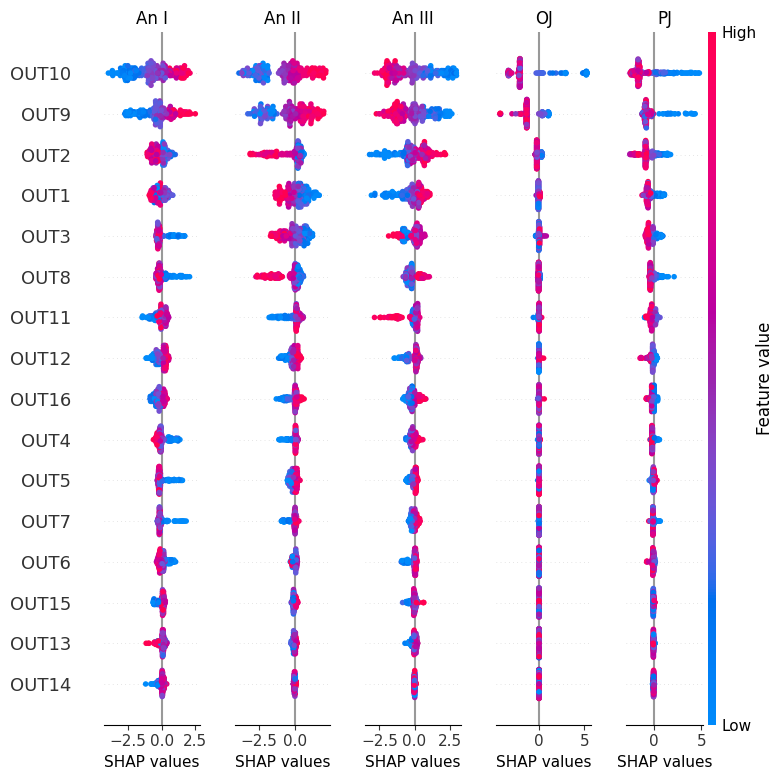

In [142]:
fig = plt.figure(figsize=(8, 6))
for i in range(len(true_labels)):
    ax = fig.add_subplot(1, len(true_labels), i+1)
    ax.title.set_text(f'{true_labels[i]}')
    if i == len(true_labels)-1:
        color = True
    else:
        color = False
    shap.summary_plot(shap_values[i], X_test, feature_names=col, show=False, color_bar=color)
    if i != 0:
        ax.set_yticks([])
    ax.set_xlabel(r'SHAP values', fontsize=11)
plt.tight_layout()

Text(0.5, 0, 'SHAP values')

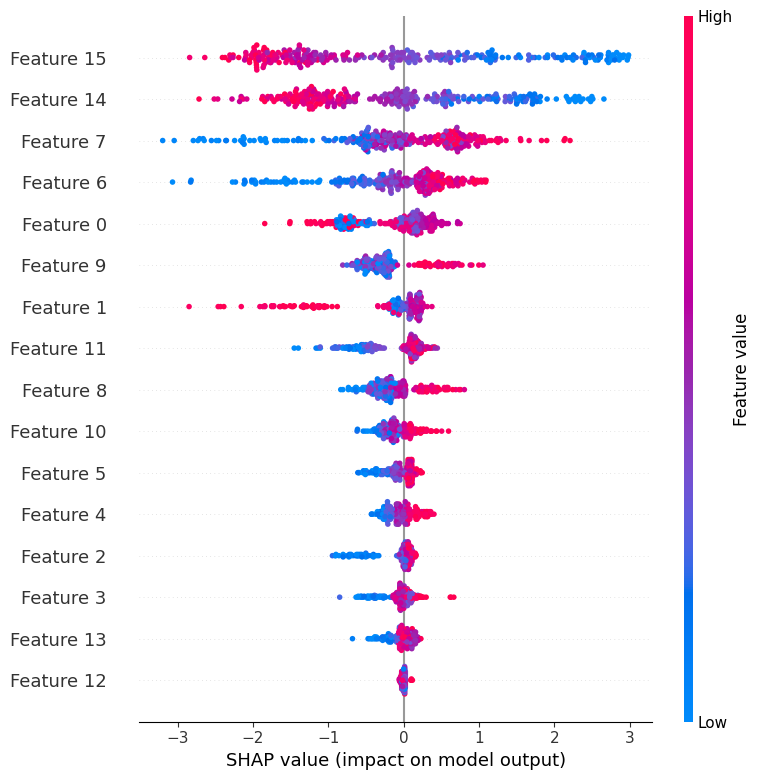

In [121]:
ax0 = fig.add_subplot(131)
ax0.title.set_text('Class 2 - Best ')
shap.summary_plot(shap_values[2], X_test, show=False, class_names=true_labels[2])
ax0.set_xlabel(r'SHAP values', fontsize=11)